# Building Recommender System With Surprise Library

### <font color=blue> We’ll be working with the Book-Crossing data set. It comprises three tables, we will use two of them: The users table and the Book ratings table and using these two tables we will recommend the books to the users focussing on Collaborative Filtering approach. Collaborative Filtering in short means the user is recommended items that people with similar tastes and preferences liked in the past. </font>

## Loading Required Libraries

In [5]:
import os
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [6]:
user = pd.read_csv('data/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('data/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

In [7]:
user.head()

userID                            Location   Age
0       1                  nyc, new york, usa   NaN
1       2           stockton, california, usa  18.0
2       3     moscow, yukon territory, russia   NaN
3       4           porto, v.n.gaia, portugal  17.0
4       5  farnborough, hants, united kingdom   NaN

In [8]:
rating.head()

userID        ISBN  bookRating
0  276725  034545104X           0
1  276726  0155061224           5
2  276727  0446520802           0
3  276729  052165615X           3
4  276729  0521795028           6

In [9]:
df = pd.merge(user, rating, on='userID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)

In [10]:
df.head()

userID        ISBN  bookRating
0       2  0195153448           0
1       7   034542252           0
2       8  0002005018           5
3       8  0060973129           0
4       8  0374157065           0

In [11]:
df.shape

(1149780, 3)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
userID        1149780 non-null int64
ISBN          1149780 non-null object
bookRating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 35.1+ MB


In [13]:
print('Dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::200000, :])

Dataset shape: (1149780, 3)
-Dataset examples-
         userID        ISBN  bookRating
0             2  0195153448           0
200000    48494  0871233428           0
400000    98391  0670032549          10
600000   147513  0470832525           5
800000   196502  0590431862           0
1000000  242157  0732275865           0


## EDA

### Ratings Distribution

In [18]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['bookRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We can see that more than 60% of all ratings in the data are 0, and only 1.7% of the ratings are 1,2, or 3, low rating books mean they are generally really bad.

### Ratings Distribution By Book

In [19]:
# Number of ratings per book
data = df.groupby('ISBN')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [20]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

ISBN  bookRating
247408  0971880107        2502
47371   0316666343        1295
83359   0385504209         883
9637    0060928336         732
41007   0312195516         723
101670  044023722X         647
166705  0679781587         639
28153   0142001740         615
166434  067976402X         614
153620  0671027360         586

Most of the books received less than 5 ratings, and very few books have many ratings, although the most rated book has received 2,502 ratings.

### Ratings Distribution By User

In [21]:
# Number of ratings per user
data = df.groupby('userID')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [22]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

userID  bookRating
4213     11676       13602
74815   198711        7550
58113   153662        6109
37356    98391        5891
13576    35859        5850
80185   212898        4785
105111  278418        4533
28884    76352        3367
42037   110973        3100
88584   235105        3067

Most of the users gave less than 5 ratings, and very few users gave many ratings.The most productive user has given 13,602 ratings.

The above two charts share the same distribution. The number of ratings per movie and the number of ratings per user decay exponentially.

To reduce the dimensionality of the dataset, we filter out rarely rated movies and rarely rating users.

In [23]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1149780, 3)
The new data frame shape:	(140516, 3)


## Surprise

To load a dataset from a pandas dataframe, we will use the __load_from_df()__ method.

we will also need a Reader object, and the rating_scale parameter must be specified. 

In [24]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

With the Surprise library, we will benchmark the following algorithms

### Basic algorithms

#### NormalPredictor

* NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

#### BaselineOnly

* BasiclineOnly algorithm predicts the baseline estimate for given user and item.

### k-NN algorithms

#### KNNBasic

* KNNBasic is a basic collaborative filtering algorithm.

#### KNNBaseline

* KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

### Matrix Factorization-based algorithms

#### SVD

* SVD algorithm is equivalent to Probabilistic Matrix Factorization (http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)

#### NMF

* NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.


<font color=red> We will use __RMSE__ as our accuracy metric for the predictions. </font>

In [25]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic(),KNNBaseline(), BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [26]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [27]:
surprise_results

test_rmse  fit_time  test_time
Algorithm                                      
BaselineOnly      3.375669  0.300113   0.464402
KNNBaseline       3.491559  1.137834   8.338581
SVD               3.542606  8.603783   0.563128
KNNBasic          3.726685  0.921802   6.671265
NMF               3.845331  8.513895   0.461991
NormalPredictor   4.669252  0.183788   0.503150

__BaselineOnly__ algorithm gave us the best rmse, therefore, we will proceed further with __BaselineOnly__ and use Alternating Least Squares (ALS).

In [28]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([3.37687523, 3.37343328, 3.37522722]),
 'fit_time': (0.15564227104187012, 0.1841139793395996, 0.1987457275390625),
 'test_time': (0.4340240955352783, 0.3219480514526367, 0.37293004989624023)}

We use the train_test_split() to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse. We’ll then use the fit() method which will train the algorithm on the trainset, and the test() method which will return the predictions made from the testset

In [29]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.3796


3.37955259868995

In [30]:
# dump.dump('./dump_file', predictions, algo)
# predictions, algo = dump.load('./dump_file')

In [31]:
trainset = algo.trainset
print(algo.__class__.__name__)

BaselineOnly


To inspect our predictions in details, we are going to build a data frame with all the predictions.

In [32]:
def get_Iu(uid):
    """ 
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ 
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [29]:
df.head()

uid         iid   rui       est                    details   Iu   Ui  \
0  114368  0553285785  10.0  5.127254  {'was_impossible': False}  120   49   
1   67403  0425147363   0.0  0.257833  {'was_impossible': False}   22   60   
2   13552  0373243286   0.0  2.334714  {'was_impossible': False}  205   47   
3  193529  0451169522   8.0  4.854099  {'was_impossible': False}   28   54   
4   70538  0804114986   0.0  2.009857  {'was_impossible': False}   10  113   

        err  
0  4.872746  
1  0.257833  
2  2.334714  
3  3.145901  
4  2.009857

In [30]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [31]:
best_predictions

uid         iid  rui  est                    details   Iu   Ui  err
2085    33974  0553581554  0.0  0.0  {'was_impossible': False}   84   56  0.0
11056   32195  0440211891  0.0  0.0  {'was_impossible': False}   97   40  0.0
17140  180957  0515113328  0.0  0.0  {'was_impossible': False}   52   33  0.0
25787  238526  0553275976  0.0  0.0  {'was_impossible': False}   72   86  0.0
31660   76942  0971880107  0.0  0.0  {'was_impossible': False}  104  637  0.0
31088  256407  0440237416  0.0  0.0  {'was_impossible': False}  138   20  0.0
19587   82893  0971880107  0.0  0.0  {'was_impossible': False}   52  637  0.0
11054   76352  0451207521  0.0  0.0  {'was_impossible': False}  508   40  0.0
28039  238120  0553275976  0.0  0.0  {'was_impossible': False}  322   86  0.0
17153   87746  0345427637  0.0  0.0  {'was_impossible': False}  161   75  0.0

The above are the best predictions, and they are not lucky guesses. Because Ui is anywhere between 26 to 146, they are not really small, meaning that significant number of users have rated the target book.

In [32]:
worst_predictions

uid         iid   rui       est                    details   Iu  \
8351   226006  0425100650  10.0  0.360752  {'was_impossible': False}   12   
31623    3363  0064405176  10.0  0.359836  {'was_impossible': False}  104   
7068   166123  0449221504  10.0  0.319006  {'was_impossible': False}  185   
28211  253106  0316781266  10.0  0.272146  {'was_impossible': False}   35   
11213  172030  0425125467  10.0  0.196301  {'was_impossible': False}  108   
23124   14521  0440222656  10.0  0.094097  {'was_impossible': False}  170   
6468    26544  0515128600  10.0  0.064665  {'was_impossible': False}  188   
32144   91832  0440241537  10.0  0.000000  {'was_impossible': False}   97   
12566   55548  0553278398  10.0  0.000000  {'was_impossible': False}  133   
11099   11601  0375703063  10.0  0.000000  {'was_impossible': False}  181   

        Ui        err  
8351    43   9.639248  
31623   24   9.640164  
7068    90   9.680994  
28211   76   9.727854  
11213   32   9.803699  
23124  191   9.905903  
6468    36   9.935335  
32144   72  10.000000  
12566   24  10.000000  
11099   76  10.000000

The worst predictions look pretty surprise. Let's look in more details of the last one ISBN "055358264X", the book was rated by 47 users, user "26544" rated 10, our BaselineOnly algorithm predicts 0.

In [33]:
df_new.loc[df_new['ISBN'] == '055358264X']['bookRating'].describe()

count    60.000000
mean      1.283333
std       2.969287
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      10.000000
Name: bookRating, dtype: float64

<IPython.core.display.Javascript object>


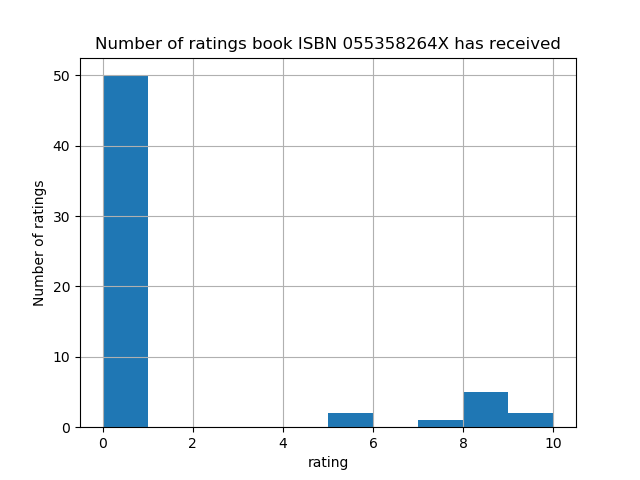

In [35]:
import matplotlib.pyplot as plt
%matplotlib notebook

df_new.loc[df_new['ISBN'] == '055358264X']['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 055358264X has received')
plt.show();

It turns out, most of the ratings this book received was "0", in another word, most of the users in the data rated this book "0", only very few users rated "10". Same with the other predictions in "worst predictions" list. It seems that for each prediction, the users are some kind of outsiders.